In [34]:
import pysal
import geopandas as gpd
# import arcpy
from pysal.model import mgwr
import pandas as pd
import numpy as np
import os
import datetime as dt 

# Visualization 
from pprint import pprint # Pretty printing
import seaborn as sns # better plotting
import matplotlib.pyplot as plt # basic plotting
from matplotlib import colors # For colormap creation 
import contextily as ctx # For basemaps

In [39]:
# Load Csv's 

cwd = os.getcwd()

data_path = os.path.join(cwd,'..', '..', 'data')
# arcpy.env.workspace = os.path.join(cwd, '..', '..', 'data', 'QAQC.gdb')

# Modeling dataframe

modeling_df = pd.read_csv(os.path.join(data_path, 'Parameter_df.csv'))

modeling_df['date'] = pd.to_datetime(modeling_df.date)

# Station Locations

stations_df = pd.read_csv(os.path.join(data_path, 'stations_5-2.csv'))

In [40]:
# Get previous day

previous_dates = modeling_df.date.dt.date - dt.timedelta(1)

for i, row in modeling_df.iterrows():
    
    previous_date = previous_dates.loc[i]
    
    sensor_id = row.sensor_index
    
    previous_readings = modeling_df[(modeling_df.date.dt.date == previous_date)&
                                   (modeling_df.sensor_index == sensor_id)].pm25_fullDay_mean
    
    if len(previous_readings) == 1:

        modeling_df.loc[i, 'pm25_fullDay_mean_yesterday'] = previous_readings.iloc[0]

    
modeling_df.head()

sensor_index       date  is_weekday  n_observations  pm25_fullDay_mean  \
0        143656 2023-03-18           0             144           5.341125   
1        142774 2022-11-05           0             144           8.901722   
2        145454 2022-12-06           1             144          11.355750   
3        142748 2022-12-07           1             144          11.848437   
4        143636 2023-01-22           0             144          24.739590   

   pm25_fullDay_minutesAbove12ug  n_spikes  humidity_fullDay_mean  \
0                            190         0                 45.833   
1                            370         0                 62.438   
2                            690         2                 48.174   
3                            560         3                 53.589   
4                           1440        50                 60.596   

   temperature_fullDay_mean  pressure_fullDay_mean  idwSum_facilities  \
0                    23.505                988.205           0.005054   
1                    42.682                973.451           0.004609   
2                    26.181                987.556          67.350629   
3                    25.477                994.330           2.827060   
4                    28.776                983.963          24.669941   

   idwSum_traffic  pm25_fullDay_mean_yesterday  
0      861.930809                     4.240750  
1      452.986261                    13.551993  
2      587.483355                     8.880667  
3     3827.349398                     7.053014  
4      453.501189                    13.688465

In [41]:
# Definitions

# Spatial Join

%run merge_dataFrame_w_featureClass.py

help(merge_dataFrame_w_featureClass)

Help on function merge_dataFrame_w_featureClass in module __main__:

merge_dataFrame_w_featureClass(df, fc_name, new_name, left_on, right_on, field_types)
    df should be a pandas dataframe
    fc_name should be a string referring to a feature class in your GDB
    new_name should be a string for the new feature class
    left_on should be the field to merge from on the featureClass
    right_on should be the column to merge from the dataframe
    field_types should be a list of ESRI field types - 
    see https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/add-fields.htm



In [119]:
def plot_GWR(data, results, predictors, title):
    '''This function will plot GWR Results and save the figure'''
    
    # Plot Betas and R^2

    betas = results.params # Coefficients from model
    
    n_plots = betas.shape[1] + 1
    
    if n_plots == 4:
        f,axs=plt.subplots(2,2, figsize=(18,18),subplot_kw=dict(aspect='equal')) # initialize a figure
    elif n_plots == 6:
        f, axs = plt.subplots(2,3, figsize = (27,18), subplot_kw=dict(aspect='equal'))
    else:
        f,axs=plt.subplots(3,n_plots, figsize=(18,6),subplot_kw=dict(aspect='equal')) # initialize a figure

    for i, ax in enumerate(axs.flatten()): # Loop through subplots

        if i == len(predictors) + 1: break # Break out of loop for final plot (R^2)

        db_to_plot = data.assign(beta_i = betas.T[i]) # Assign beta_i's to original dataframe
        
        vmin = min(betas.T[i])
        vmax = max(betas.T[i])
        
        if vmin >= 0:
            vcenter = np.median(betas.T[i])
            cmap = 'YlGn'
            
        elif vmin < 0 and vmax > 0:
            vcenter = 0
            cmap = 'PiYG'
        else:
            vcenter = np.median(betas.T[i])
            cmap = 'RdPu_r'

        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        
        db_to_plot.plot(column='beta_i',cmap=cmap,marker='.',ax=ax,legend=True, norm = norm, s=500) # Plot beta_i's
        # Add colorbar, make sure to specify tick locations to match desired ticklabels

        # base map
        ctx.add_basemap(ax, 
                    crs=data.crs, 
                    source=ctx.providers.Stamen.TonerHybrid,
                    zorder=-1, # plot behind all other plots
                    alpha=0.5
                   )

        # set the title of the plot to be the name of the variable:
        if i==0:
            ax.set_title(r'$\beta$ of Constant',fontsize=16)
        else: 
            ax.set_title(r'$\beta$ of '+ predictors[i-1],fontsize=16)
        ax.set_axis_off() # Remove Axis labels


    last_ax = axs.flatten()[-1] # Get last subplot

    rdata = data.assign(r2=results.localR2)

    rdata[rdata['r2'] > 0].plot(column='r2', cmap='Reds', ax = last_ax, legend=True, marker='.', s=500) # plot R^2 values

    # base map
    ctx.add_basemap(ax = last_ax,
                    crs=data.crs,
                    source=ctx.providers.Stamen.TonerHybrid,
                    zorder=-1,
                    alpha=0.5)

    # title/remove axes
    last_ax.set_title(r'local $R^2$',fontsize=16)
    last_ax.set_axis_off()


    f.tight_layout() # we are done!
    f.savefig(title)
    plt.show()

In [76]:
# Check out pressure and fix for model?

press = modeling_df.pressure_fullDay_mean

mean = press.mean()
std = press.std()

print('Mean: ', press.mean(),
      '\nStd: ', press.std())

press.hist(bins = 200)

# I think we will remove any outside of 4 standard deviations

press_range = [mean - 3*std, mean + 3*std]

Mean:  986.0165674404642 
Std:  9.410231526092586


In [99]:
# Clean data

# Remove pm2.5 values greater than 28
# And pressure inversions 

# ^ Nah

modeling_df_select = modeling_df#[
    # (modeling_df.pm25_fullDay_mean < 28)&
                                 # (modeling_df.pressure_fullDay_mean > press_range[0])&
                                  # (modeling_df.pressure_fullDay_mean < press_range[1])
                                  # ].copy()

# Making pressure on similar scale as other variables

# modeling_df_select['pressure_fullDay_mean'] = modeling_df.pressure_fullDay_mean/10

no_nans = modeling_df_select.dropna().copy() # Drop NA

# Remove 

# Add month

no_nans['month'] = no_nans.date.dt.month.astype(str)

print(len(no_nans), len(modeling_df_select))

len(no_nans.sensor_index.unique())

9857 10372


54

In [100]:
# Merge the stations

merged_df = pd.merge(stations_df, no_nans, on='sensor_index')

merged_no_nans = merged_df.dropna().copy() # Drop nans

In [101]:
# Define important variables

y_name = 'pm25_fullDay_mean' # Dependent

x_names = [ # Independents
    'humidity_fullDay_mean', 
           'pm25_fullDay_mean_yesterday',
            'temperature_fullDay_mean',
           'pressure_fullDay_mean',
           # 'idwSum_facilities', 'idwSum_traffic'
    ]

## GWR

In [102]:
# GWR by season

# Map the season into dataframe

seasonMonth_dict = {'Winter':[12,1,2],
                    'Spring':[3,4,5],
                    'Summer':[6,7,8],
                    'Fall':[9,10,11]}

for season in seasonMonth_dict:
    
    seasonMonths = seasonMonth_dict[season]
    
    is_season = merged_no_nans.date.dt.month.isin(seasonMonths)
    
    merged_no_nans.loc[is_season, 'season'] = season

In [109]:
# GWRs 

# Set bandwidth

bw = 3000 # meters

# Define Iterable

seasons = ['Winter', 'Spring', 'Summer', 'Fall', 'All']

# Initialize Storage

model_dict = {}

for season in seasons:
    
    model_dict[season] = {}
    
    if season == 'All':
        
        select = merged_no_nans
    
    else:
        select = merged_no_nans[merged_no_nans.season == season]

    # Prepare data for GWR function

    ## Get UTM Coordinates

    utm_gdf = gpd.GeoDataFrame(select, geometry = gpd.points_from_xy(select.longitude,
                                                                          select.latitude,
                                                                          crs = 'EPSG:4326')
                                  ).to_crs('EPSG:26915')

    model_dict[season]['locations'] = utm_gdf.copy()

    coords = np.array(list(zip(utm_gdf.geometry.x, utm_gdf.geometry.y)))

    # Get arrays of the variables

    y = select.pm25_fullDay_mean.values.reshape(-1, 1)
    X = select[x_names].values

    model = mgwr.gwr.GWR(coords = coords,
                        y = y,
                        X = X,
                        fixed = True,
                        bw = bw)


    results = model.fit()

    model_dict[season]['model'] = results

Winter 

~~~~~~~


Model type                                                         Gaussian
Number of observations:                                                3420
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         495905.524
Log-likelihood:                                                  -13363.004
AIC:                                                              26736.007
AICc:                                                             26738.032
BIC:                                                             468116.317
R2:                                                                   0.542
Adj. R2:                                                              0.542

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------

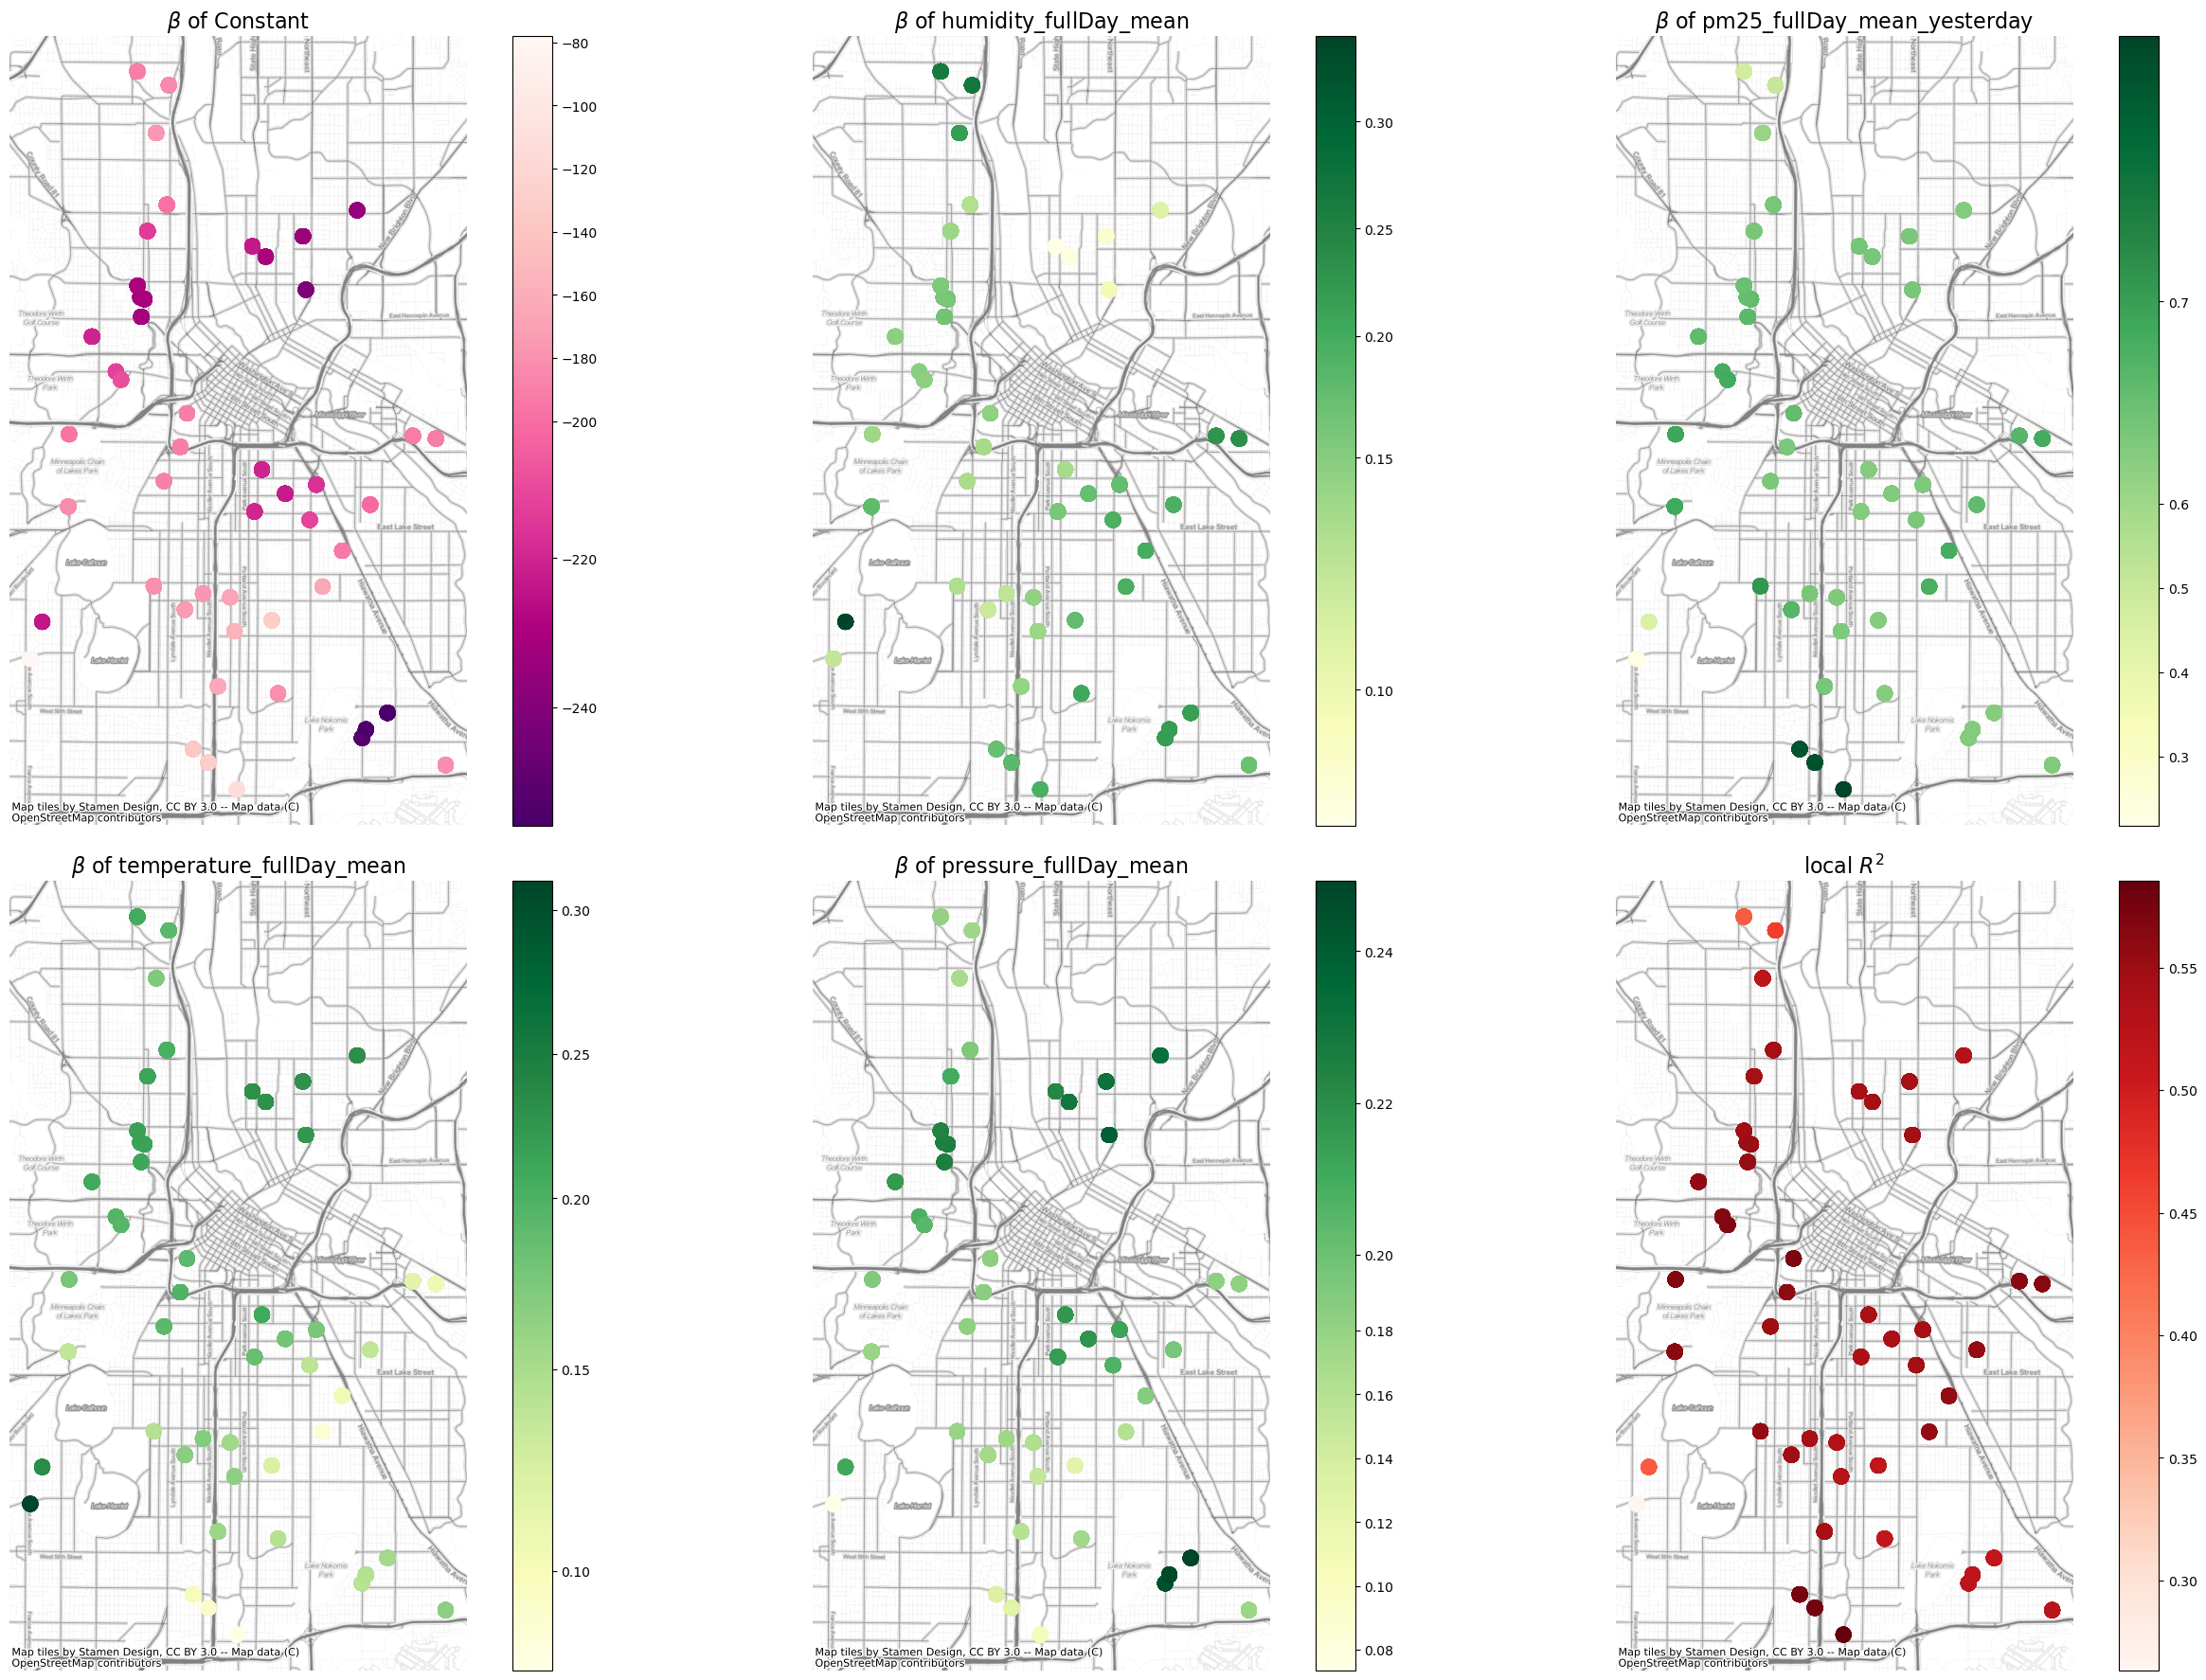

Spring 

~~~~~~~


Model type                                                         Gaussian
Number of observations:                                                2708
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         109528.111
Log-likelihood:                                                   -8852.246
AIC:                                                              17714.492
AICc:                                                             17716.523
BIC:                                                              88163.692
R2:                                                                   0.165
Adj. R2:                                                              0.163

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------

Summer 

~~~~~~~


Model type                                                         Gaussian
Number of observations:                                                1261
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          19690.374
Log-likelihood:                                                   -3522.037
AIC:                                                               7054.075
AICc:                                                              7056.142
BIC:                                                              10722.961
R2:                                                                   0.187
Adj. R2:                                                              0.184

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------

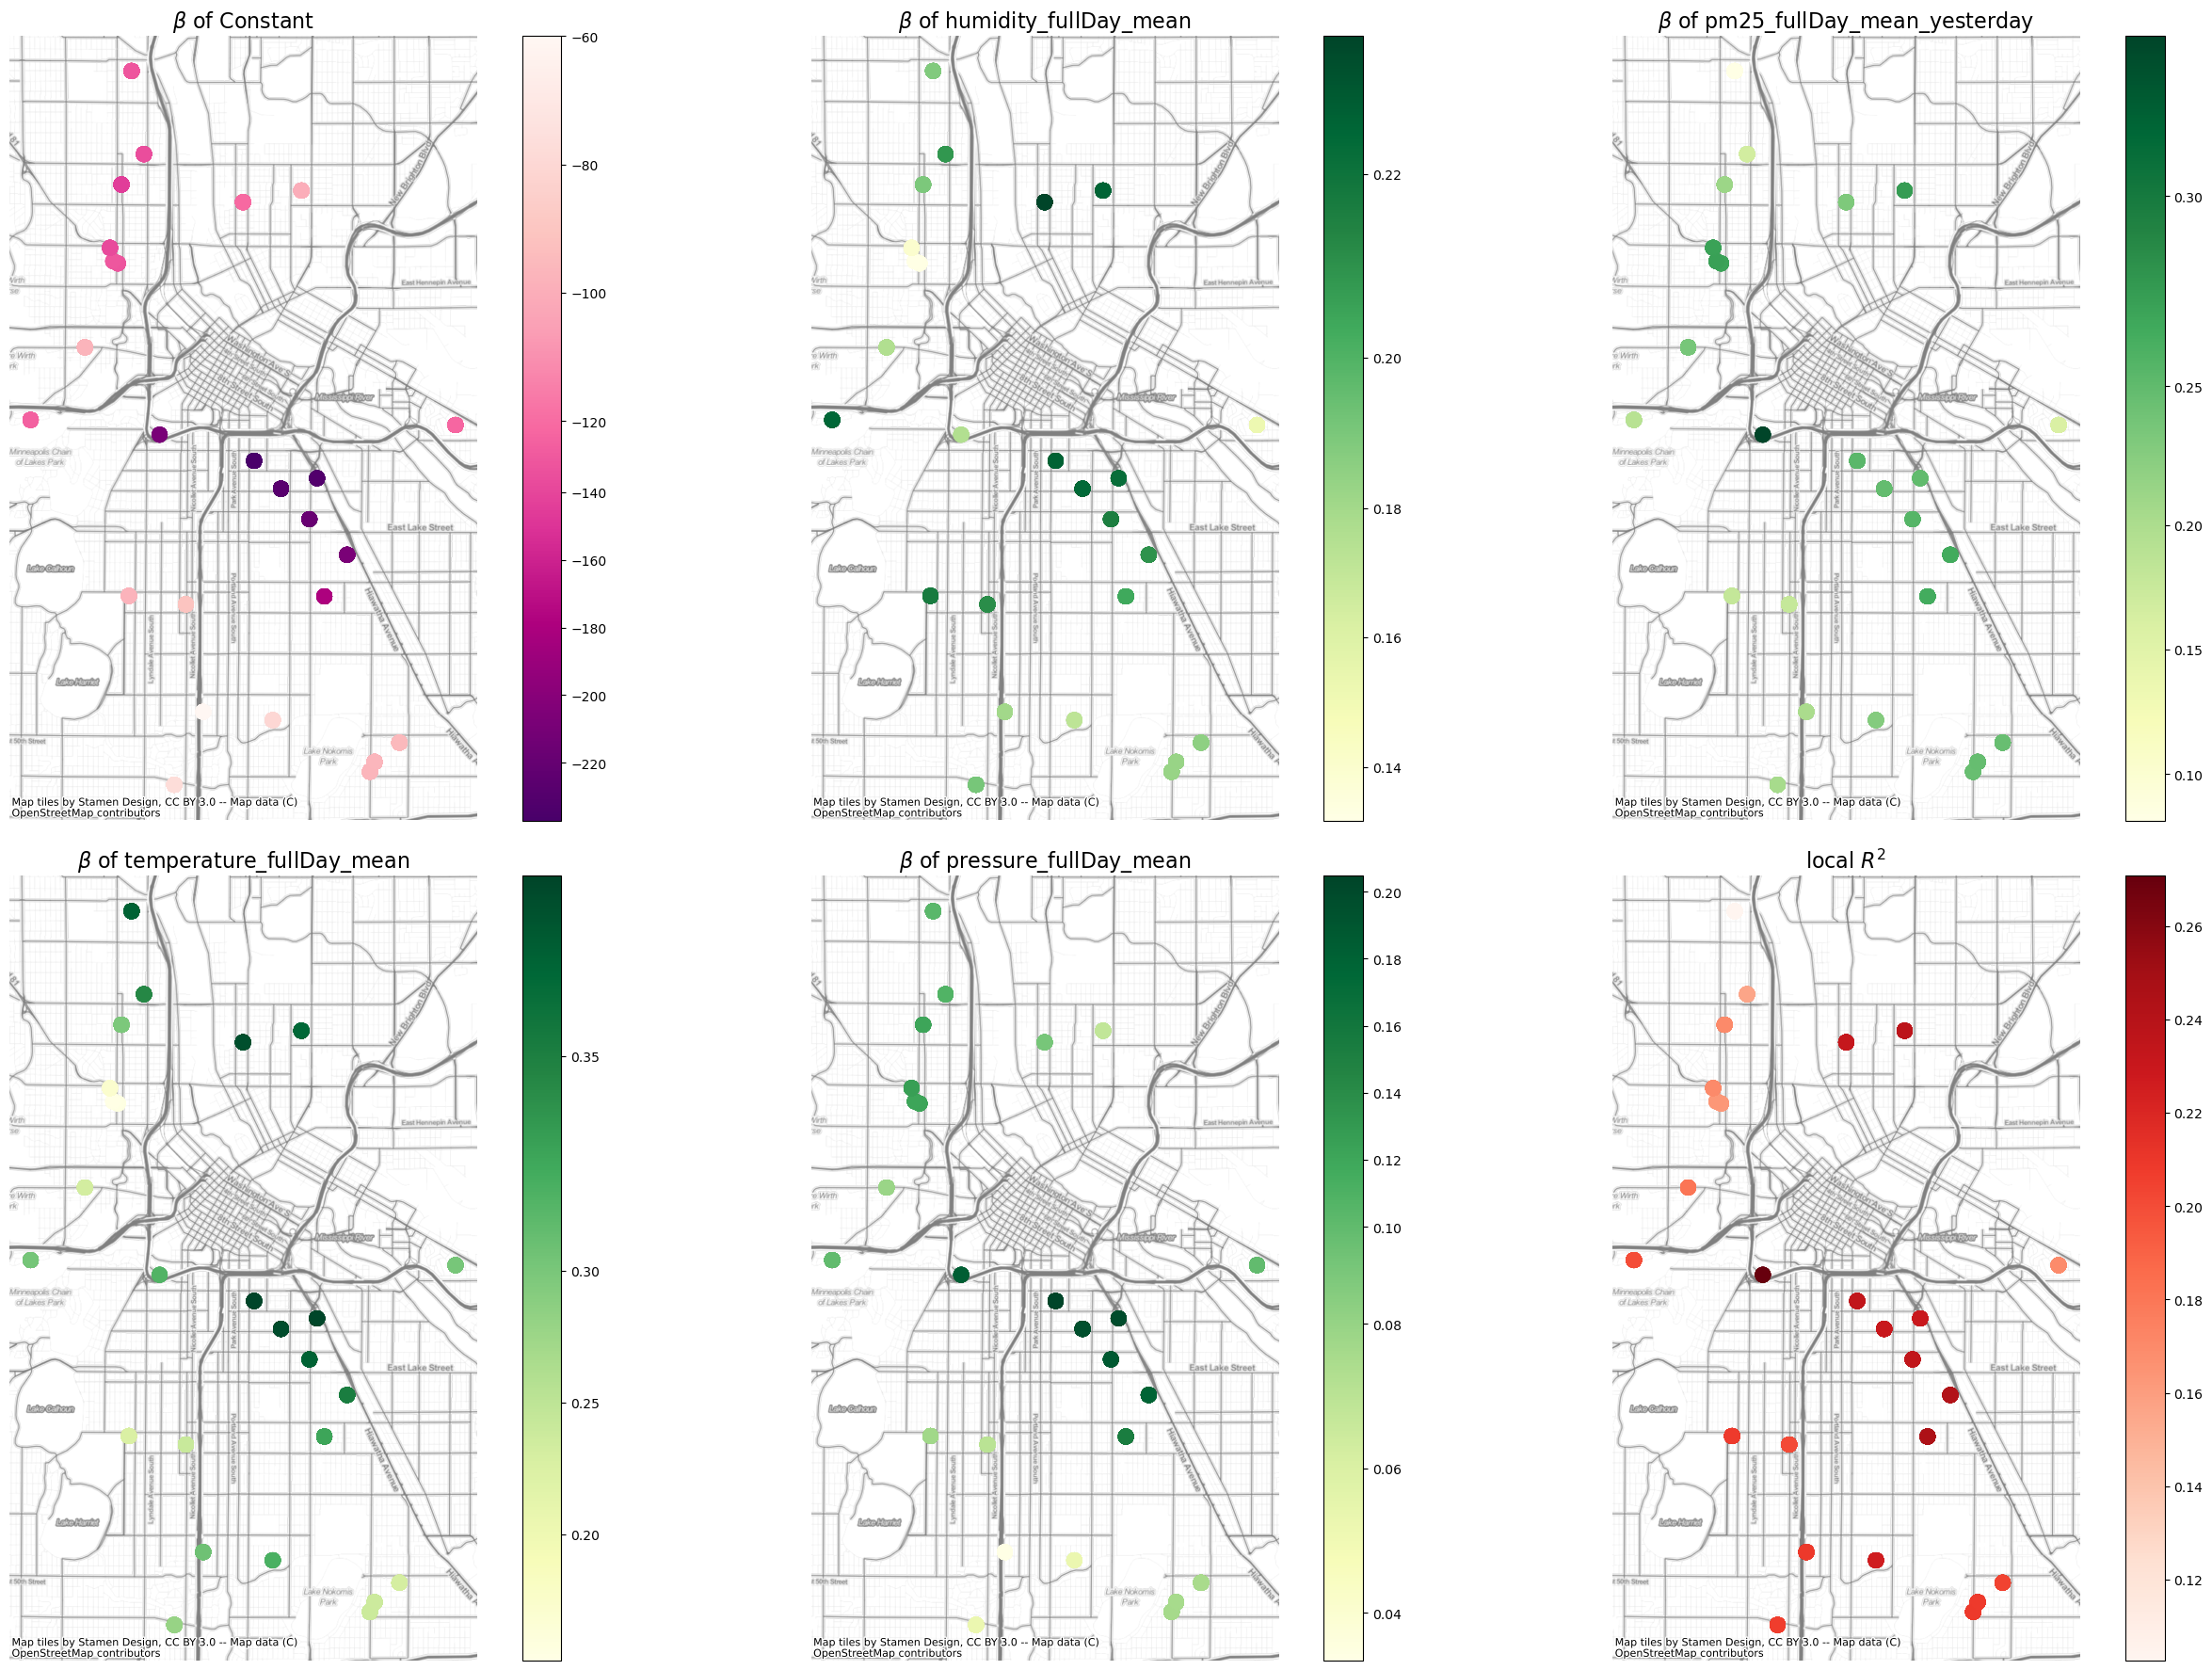

Fall 

~~~~~~~


Model type                                                         Gaussian
Number of observations:                                                2432
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         206781.963
Log-likelihood:                                                   -8853.487
AIC:                                                              17716.974
AICc:                                                             17719.008
BIC:                                                             187859.932
R2:                                                                   0.348
Adj. R2:                                                              0.347

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- 

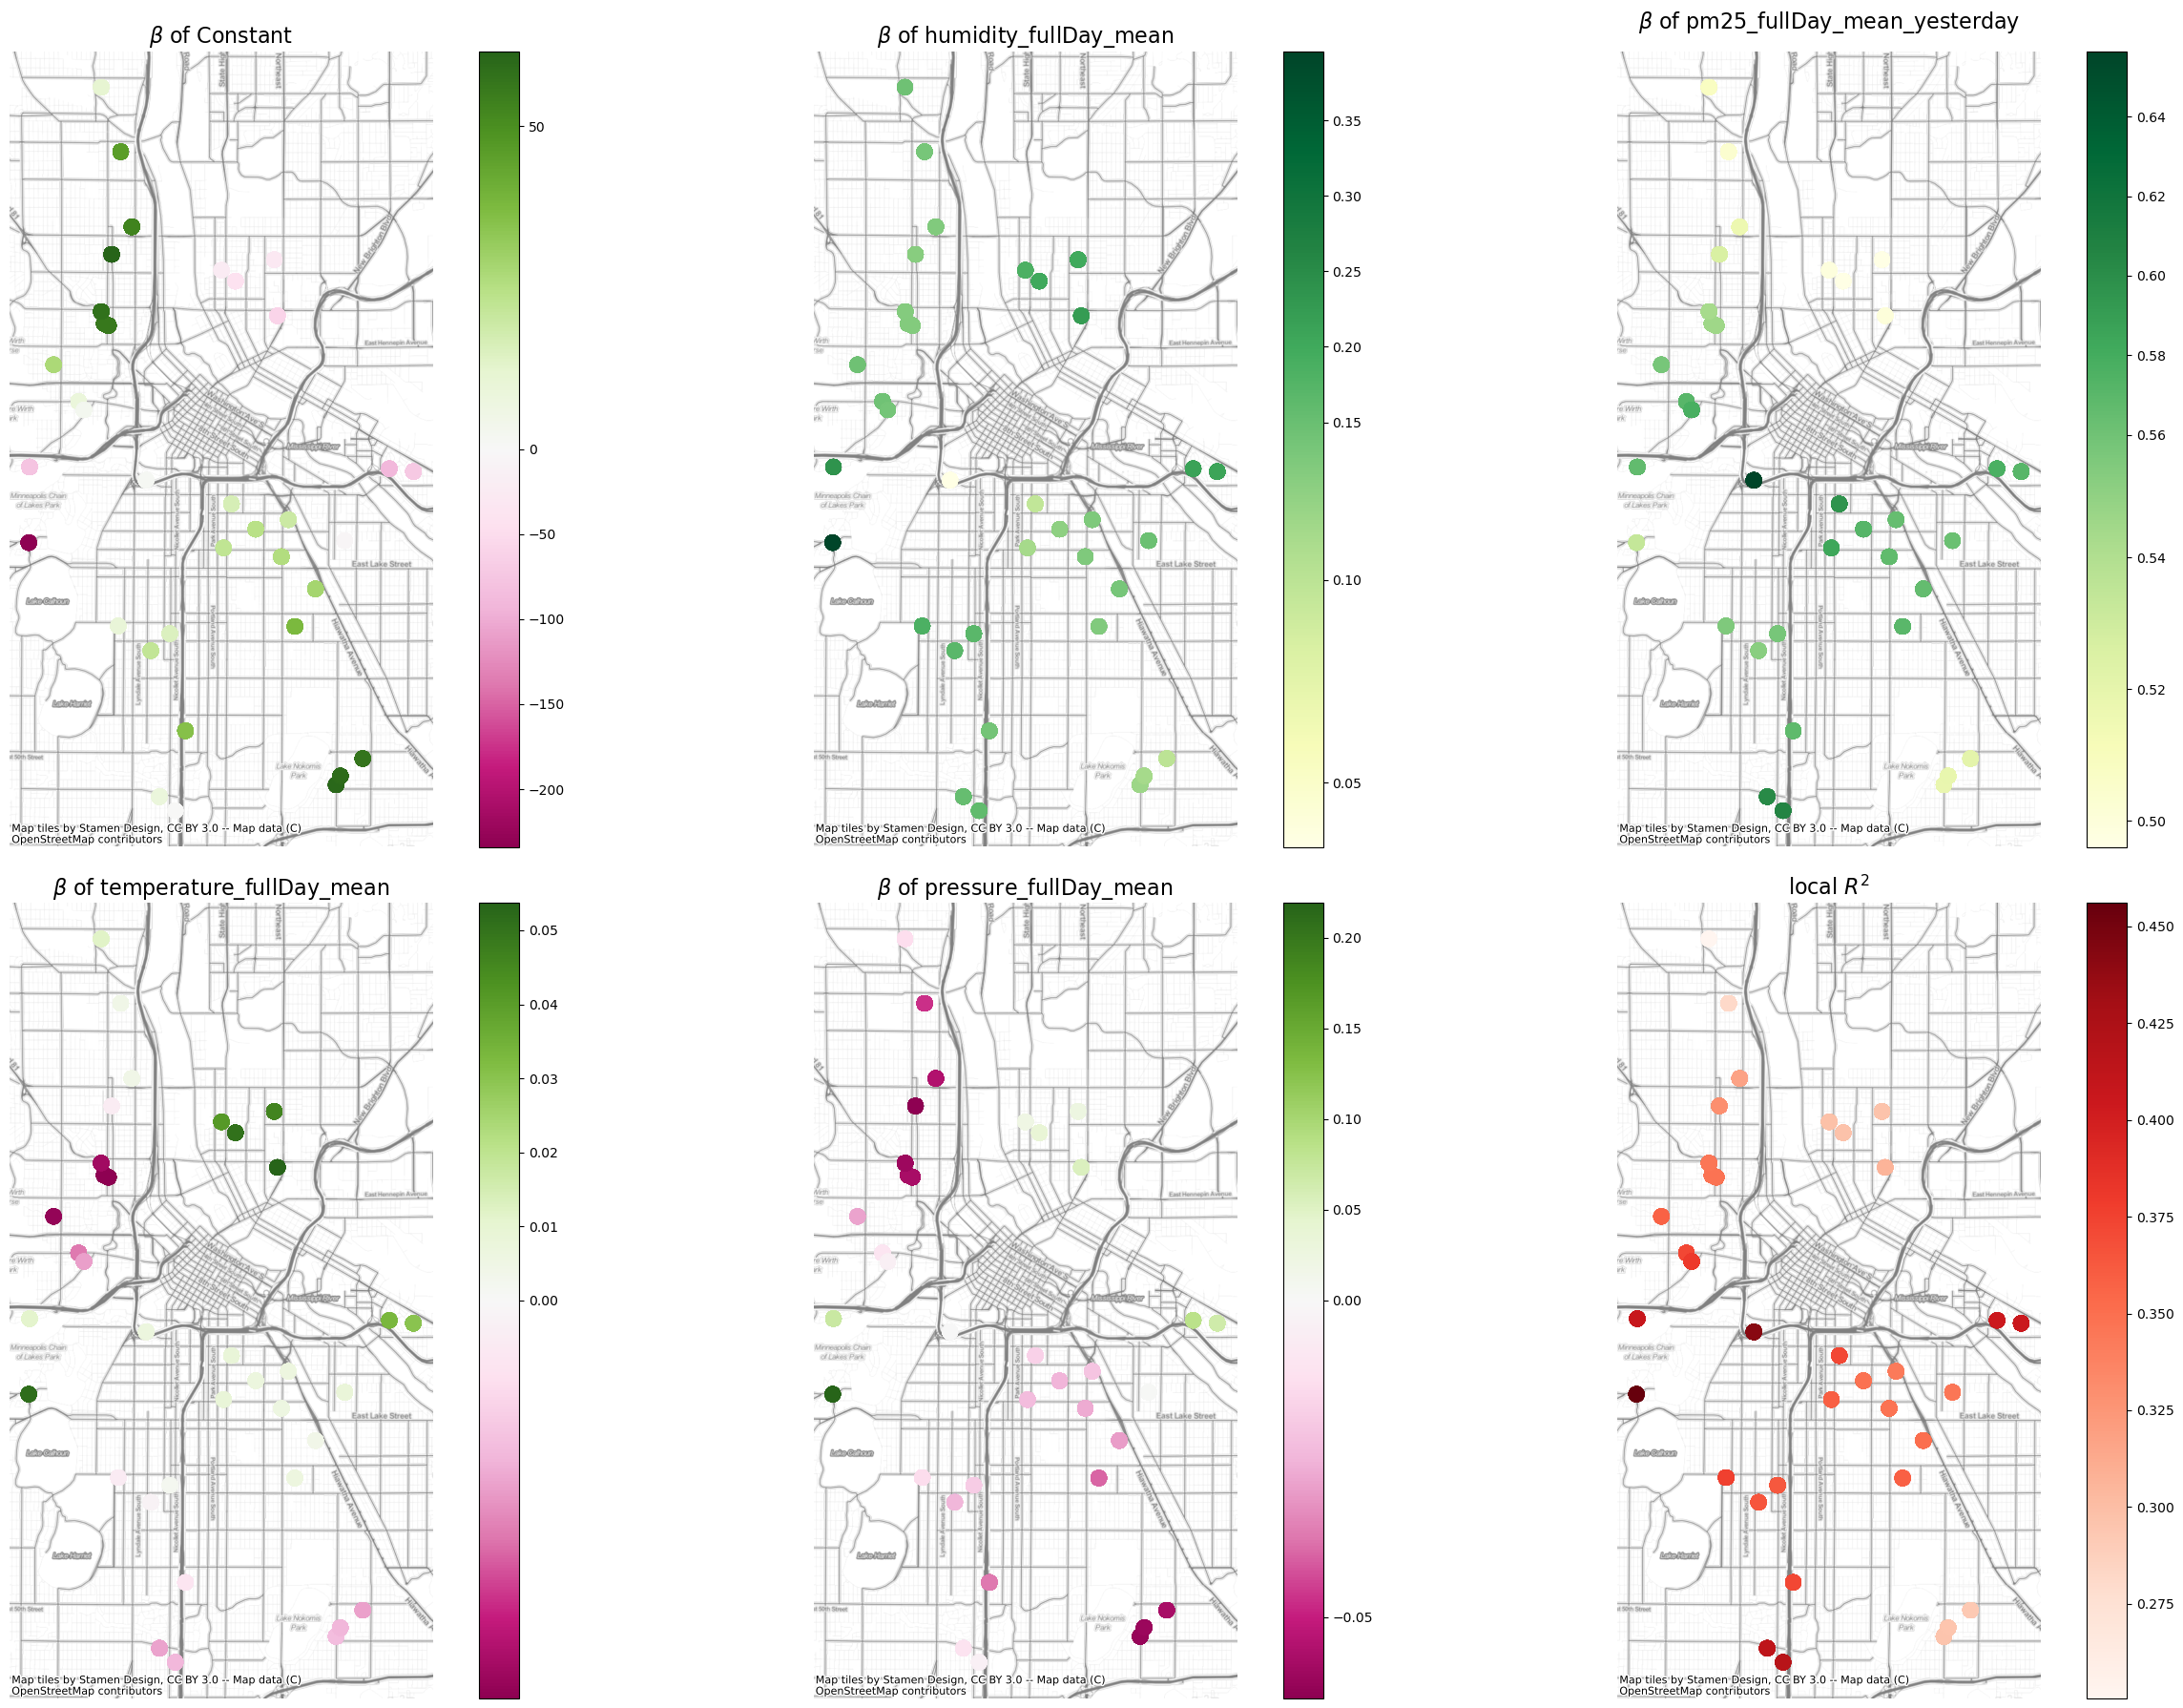

All 

~~~~~~~


Model type                                                         Gaussian
Number of observations:                                                9821
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         878206.251
Log-likelihood:                                                  -36000.032
AIC:                                                              72010.065
AICc:                                                             72012.073
BIC:                                                             787974.848
R2:                                                                   0.481
Adj. R2:                                                              0.481

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- -

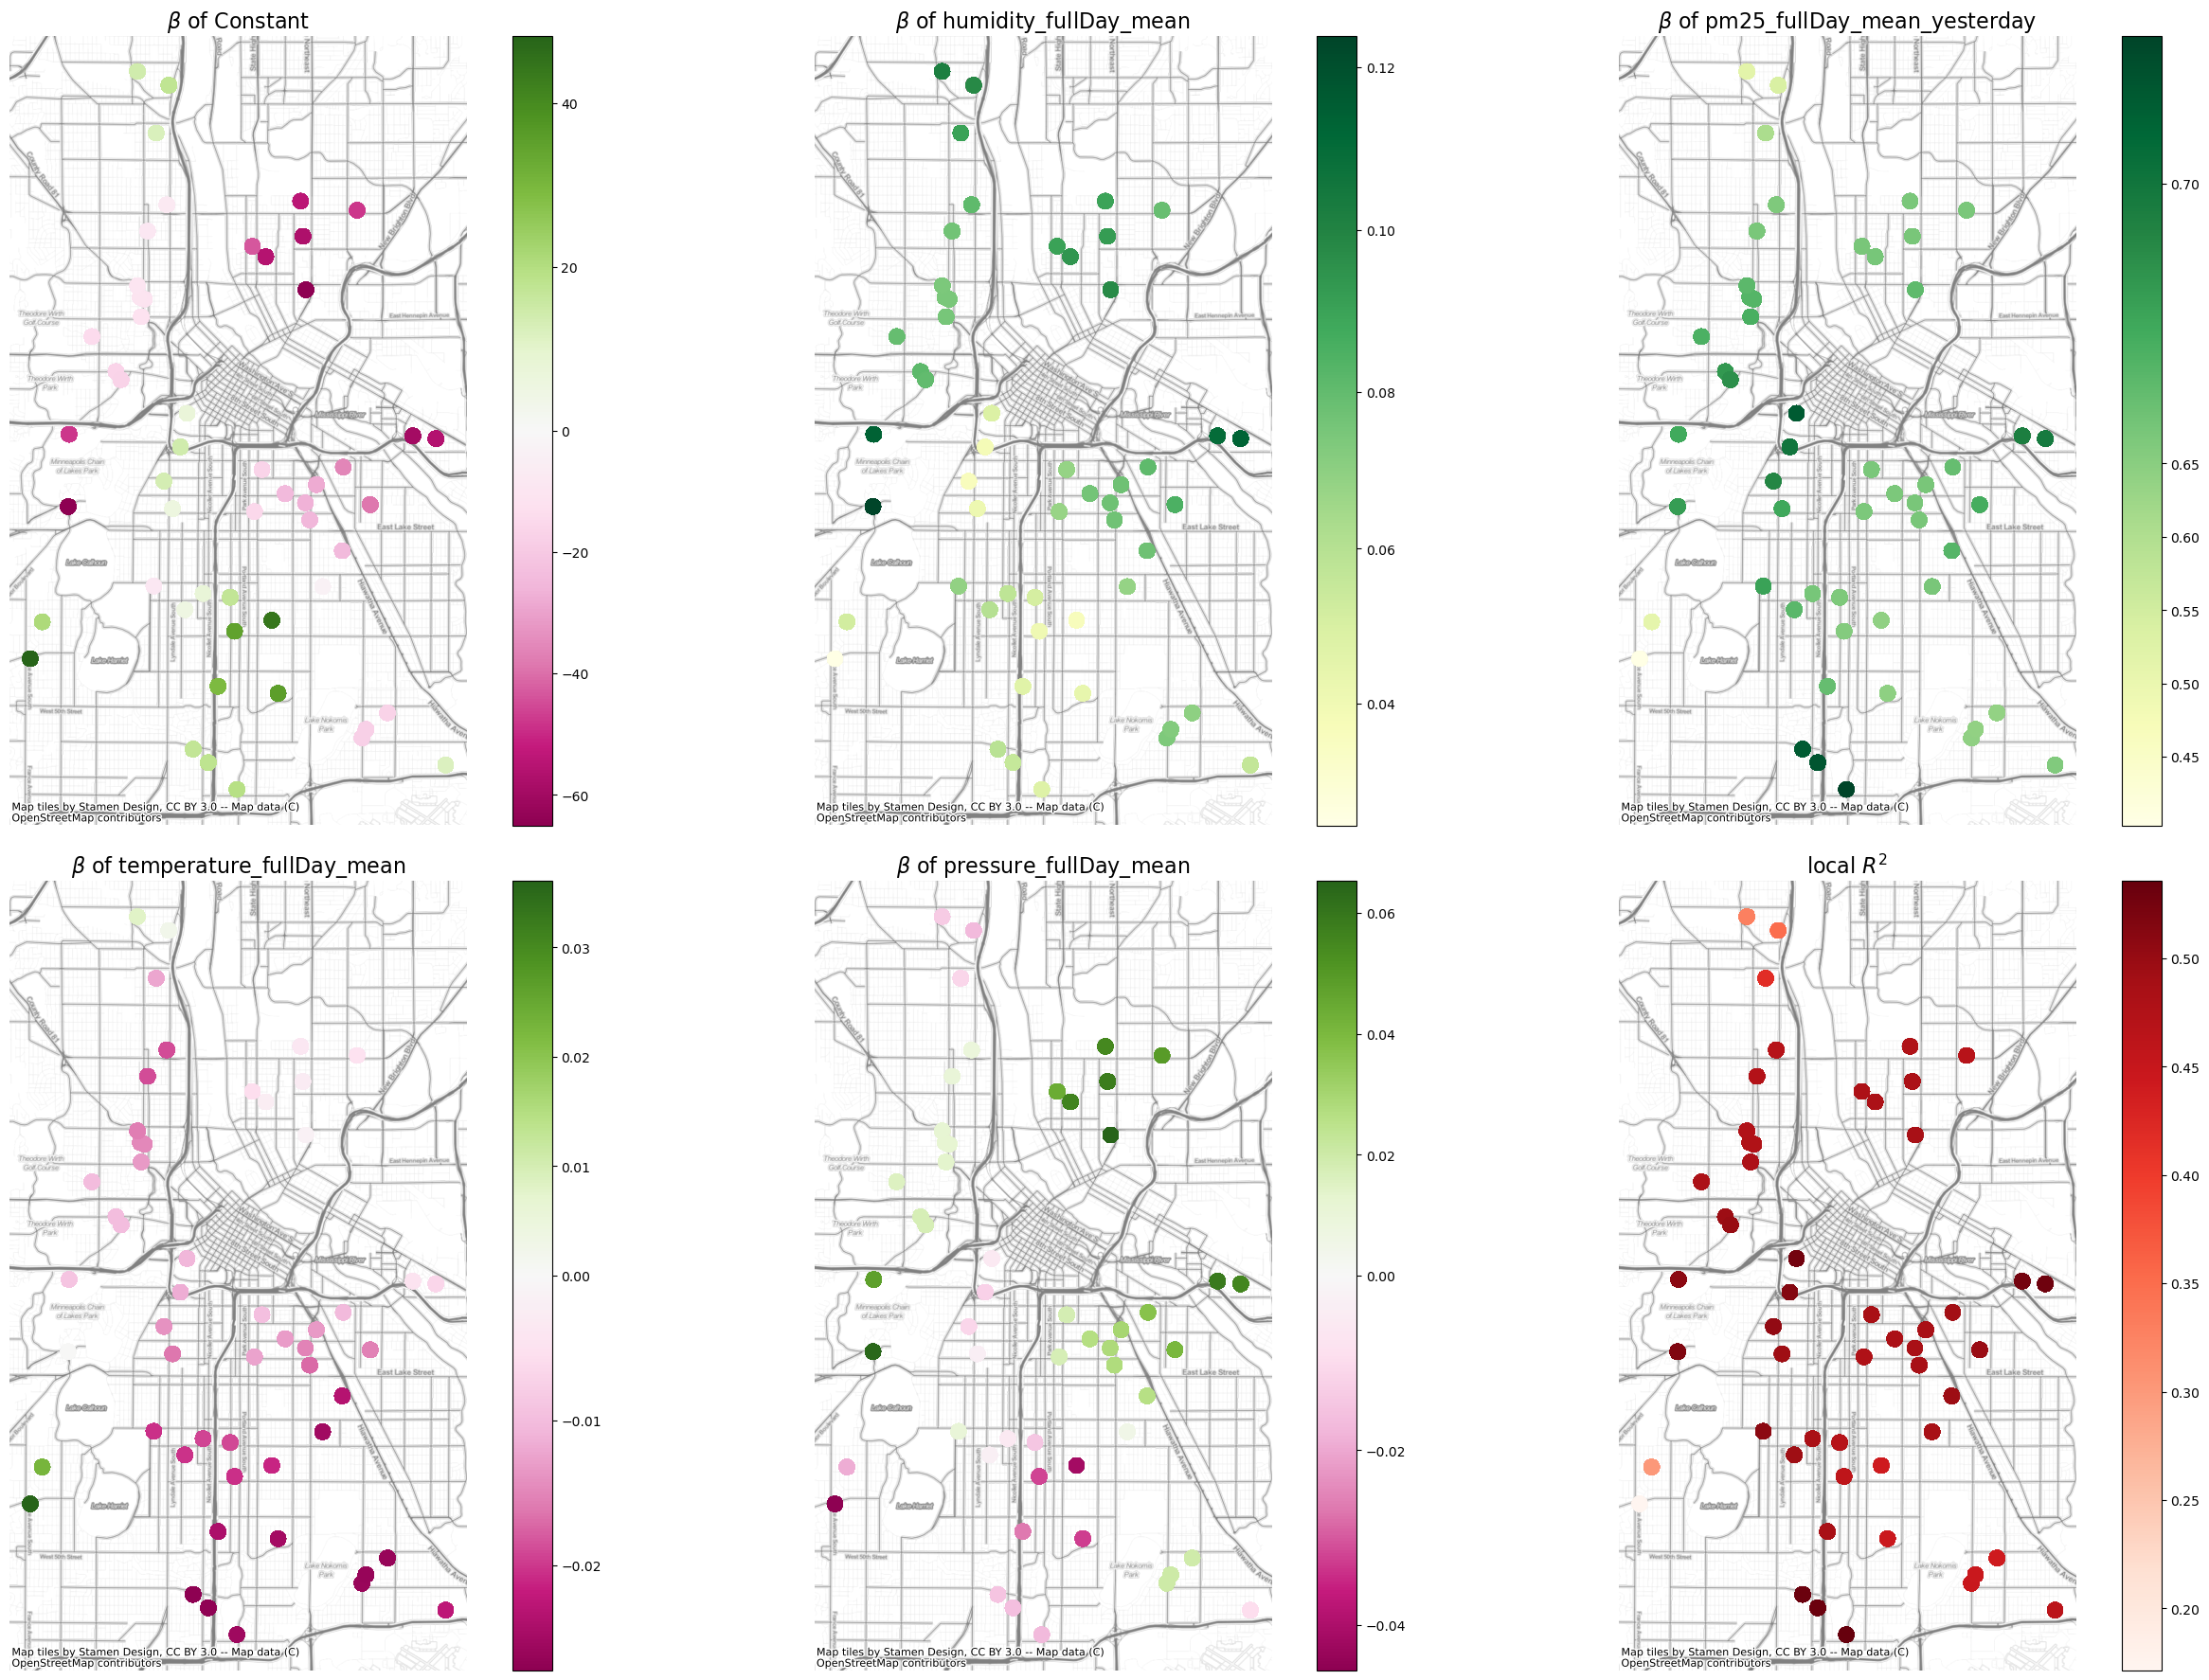

In [120]:
# Check them out!

for season in model_dict:
    
    gdf = model_dict[season]['locations']
    
    results = model_dict[season]['model']
    
    print(season, '\n\n~~~~~~~\n\n')
    
    print(results.summary())
    
    # Plot?!

    plot_GWR(gdf, results, x_names, 'GWR - ' + season)

In [123]:
# Pretend forecast!?

humidity = 85
pm_yesterday = 12
temp = 75
pressure = 930

init_params = np.array([1, humidity, pm_yesterday, temp, pressure])

forecast = np.sum(results.params * init_params, axis=1)

np.unique(forecast)

array([12.3659562 , 12.39687367, 12.48200079, 12.49481308, 12.57934532,
       12.67665139, 12.77261929, 12.90939142, 12.92651312, 12.9428238 ,
       12.9675865 , 13.09430776, 13.1015056 , 13.17631049, 13.18923671,
       13.29310173, 13.32759237, 13.33904656, 13.35368904, 13.42751593,
       13.5219134 , 13.53291649, 13.59390174, 13.60131858, 13.67714417,
       13.76295259, 13.78158873, 13.83878371, 14.01840525, 14.02505488,
       14.02746252, 14.02947168, 14.06321914, 14.07691638, 14.10331568,
       14.10426895, 14.16832973, 14.19513916, 14.25334116, 14.26416127,
       14.28525092, 14.39639742, 14.45143004, 14.50858791, 14.70891139,
       14.75146293, 14.86084625, 15.10527124, 15.23517886, 15.81649875,
       15.82395962, 16.75619586, 16.89712761])

## Different combinations of Predictors

In [153]:
from itertools import chain, combinations

# These will be the predictors

predictors = [ # Independents
    'humidity_fullDay_mean', 
           'pm25_fullDay_mean_yesterday',
            'temperature_fullDay_mean',
           'pressure_fullDay_mean',
           'idwSum_facilities', 'idwSum_traffic'
    ]

# All combinations of 2 or more

combos = chain(*map(lambda x: combinations(predictors, x), range(2, len(predictors)+1)))

print(len(list(combos)), 'Combinations')

# Giving them IDs

combos_dict = dict(zip(range(len(list(chain(*map(lambda x: combinations(predictors, x), range(2, len(predictors)+1)))))),
                       list(chain(*map(lambda x: combinations(predictors, x), range(2, len(predictors)+1))))))

# ^ To see what that's all about go here:
# https://stackoverflow.com/questions/464864/get-all-possible-2n-combinations-of-a-list-s-elements-of-any-length

57 Combinations


In [158]:
# GWRs 

# Set bandwidth

bw = 4000 # meters

# Define Iterable

seasons = ['Winter', 'Spring', 'Summer', 'Fall', 'All']

# Initialize Storage

model_dict = {}

for season in seasons:
    
    model_dict[season] = {}
    
    # Select season
    
    if season == 'All':
        
        select = merged_no_nans
    
    else:
        select = merged_no_nans[merged_no_nans.season == season]

    # Prepare data for GWR function

    ## Get UTM Coordinates

    utm_gdf = gpd.GeoDataFrame(select, geometry = gpd.points_from_xy(select.longitude,
                                                                          select.latitude,
                                                                          crs = 'EPSG:4326')
                                  ).to_crs('EPSG:26915')

    model_dict[season]['utm_gdf'] = utm_gdf.copy()

    coords = np.array(list(zip(utm_gdf.geometry.x, utm_gdf.geometry.y)))
    
    # Iterate through combinations
    
    for combo_id in combos_dict:

        # Get arrays of the variables
        
        x_list = list(combos_dict[combo_id])
        
        if x_list != ['idwSum_facilities', 'idwSum_traffic']: # Causes matrix to be singular

            y = select.pm25_fullDay_mean.values.reshape(-1, 1)
            X = select[x_list].values

            model = mgwr.gwr.GWR(coords = coords,
                                y = y,
                                X = X,
                                fixed = True,
                                bw = bw)


            results = model.fit()

            # Store the model

            model_key = str(combo_id) + '_model'

            model_dict[season][model_key] = results
            
            # print(model_key)
    print(season)

0_model
1_model
2_model
3_model
4_model
5_model
6_model
7_model
8_model
9_model
10_model
11_model
12_model
13_model
15_model
16_model
17_model
18_model
19_model
20_model
21_model
22_model
23_model
24_model
25_model
26_model
27_model
28_model
29_model
30_model
31_model
32_model
33_model
34_model
35_model
36_model
37_model
38_model
39_model
40_model
41_model
42_model
43_model
44_model
45_model
46_model
47_model
48_model
49_model
50_model
51_model
52_model
53_model
54_model
55_model
56_model
0_model
1_model
2_model
3_model
4_model
5_model
6_model
7_model
8_model
9_model
10_model
11_model
12_model
13_model
15_model
16_model
17_model
18_model
19_model
20_model
21_model
22_model
23_model
24_model
25_model
26_model
27_model
28_model
29_model
30_model
31_model
32_model
33_model
34_model
35_model
36_model
37_model
38_model
39_model
40_model
41_model
42_model
43_model
44_model
45_model
46_model
47_model
48_model
49_model
50_model
51_model
52_model
53_model
54_model
55_model
56_model
0_model
1_mo

In [204]:
# Unpack those results!

# https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWRResults.html

cols =  ['season', 'combo_id', 'rmse', 'rsquared', 'aic', 'bic']

results_df = pd.DataFrame(columns = cols)

season_bests = {}

for season in model_dict:
    
    season_best = (None, 0, float('inf')) # Combo_id, R^2, AIC
    
    for combo_id in model_dict[season]:
        
        if combo_id != 'utm_gdf':
            
            results = model_dict[season][combo_id]
            
            predicted = results.predy
                
            rmse = np.sum((results.y - predicted.T)**2/len(results.y))
            
            r2 = results.R2
            
            aic = results.aic

            row = [season, combo_id, rmse, r2, aic, results.bic]

            results_df.loc[len(results_df)] = row
            
            # Pick best model
            # https://www.scribbr.com/statistics/akaike-information-criterion/
            
            if r2 > season_best[1]:
                
                if aic < season_best[2]:
                    
                    season_best = (combo_id, r2, aic)
                    
    season_bests[season] = season_best

In [205]:
season_bests

{'Winter': ('35_model', 0.5454064709636095, 26795.171977661408),
 'Spring': ('0_model', 0.16621187861576459, 17757.53532869302),
 'Summer': ('51_model', 0.22729137034564673, 7066.257797300925),
 'Fall': ('0_model', 0.35169539988727605, 17744.58596779262),
 'All': ('0_model', 0.4818445917165416, 72036.3031110755)}

In [206]:
# Winter model

combos_dict[35]

('humidity_fullDay_mean',
 'pm25_fullDay_mean_yesterday',
 'temperature_fullDay_mean',
 'pressure_fullDay_mean')

In [209]:
# Summer model

combos_dict[51]

('humidity_fullDay_mean',
 'pm25_fullDay_mean_yesterday',
 'temperature_fullDay_mean',
 'pressure_fullDay_mean',
 'idwSum_traffic')

In [211]:
# Fall, All, Spring Model

combos_dict[0]

('humidity_fullDay_mean', 'pm25_fullDay_mean_yesterday')

In [238]:
# Best models
# To actually predict, we may need to do something with this
# https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWR.predict.html

for season in season_bests:

    # Get the model information
    
    combo_key = season_bests[season][0] # Key in the model dictionary
    
    combo_id = int(combo_key.split('_')[0]) # Key in the predictor combos dictionary
    
    x_names = list(combos_dict[combo_id]) # Predictors
    
    betas = model_dict[season][combo_key].params # betas
    
    # Add the betas to a geodataframe
    
    gdf = model_dict[season]['utm_gdf'].copy()[['sensor_index', 
                                                'name', 'latitude', 
                                                'longitude', 'geometry']]
    
    for i, name in enumerate(['constant'] + x_names):
        
        coef_name = name + '_beta'
        
        gdf.loc[:, coef_name] = betas.T[i]
        
        
    # Drop the duplicate rows
    
    gdf = gdf.drop_duplicates(ignore_index = True).copy()
    
    # Save as a geojson
    
    name = season + '_bestModel.geojson'
    
    gdf.to_file(name)